In [1]:
import PollingSystem as PS
import MarkovianRP as MRP
import numpy as np

from matplotlib import pyplot as plt

In [23]:
ps = PS.PollingSystem([1, 1, 1], 0.0001)

rp = MRP.RandomRP([1/3, 1/3, 1/3])
s12 = [0.00001, 0.00005,0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20]
d = 500
for s in s12:
    S =  np.array([[0, s, d],[s, 0, np.sqrt(d+s**2)],[1.5, np.sqrt(d+s**2), 0]])
    wait = ps.calc_avg_wait(rp, S)
    print("Theoretical Wait Time: %f"%(wait))

Theoretical Wait Time: 351.181336
Theoretical Wait Time: 351.181320
Theoretical Wait Time: 351.181300
Theoretical Wait Time: 351.180943
Theoretical Wait Time: 351.179356
Theoretical Wait Time: 351.177373
Theoretical Wait Time: 351.161500
Theoretical Wait Time: 351.141649
Theoretical Wait Time: 350.982471
Theoretical Wait Time: 350.782628
Theoretical Wait Time: 350.380404
Theoretical Wait Time: 349.161554
Theoretical Wait Time: 347.152509
Theoretical Wait Time: 343.683711


In [3]:
#NOTE: decreasing switching time does NOT guarantee decreasing average waiting time

In [45]:
ps = PS.PollingSystem([1, 0.5, 0.5], 0.1)
#P = np.array([[0, 0.2, 0.8],[0.4, 0, 0.6],[0.5, 0.5, 0]])
#rp = MRP.MarkovianRP(P)
rp = MRP.RandomRP([1/3, 1/4, 5/12])
S =  np.array([[0, 5, 1],[5, 0, np.sqrt(6)],[1,np.sqrt(6), 0]])
wait = ps.calc_avg_wait(rp, S)
print("Theoretical Wait Time: %.4f"%(wait))
xt, wt, queues = ps.simulate(rp, S, 500)

Theoretical Wait Time: 5.8438
System Average Wait Time: 6.1652


In [46]:
def tail_avg_wait(queues, tail_start, Ls):
    avg = 0
    for i in range(len(queues)):
        queue = queues[i]
        sst = queue.service_start_times
        upper_i = len(sst) - 1
        lower_i = 0
        while upper_i - lower_i != 1:
            test_i = (upper_i + lower_i)//2
            if sst[test_i] < tail_start:
                lower_i = test_i
            elif sst[test_i] > tail_start:
                upper_i = test_i
            else:
                upper_i = test_i
                lower_i = test_i-1
        q_tail = queue.wait_times[upper_i:]
        avg += Ls[i]*np.mean(q_tail)
    return avg/np.sum(Ls)

tail_avg_wait(queues, 300, [0.2, 1, 0.4])

5.9078573477403795

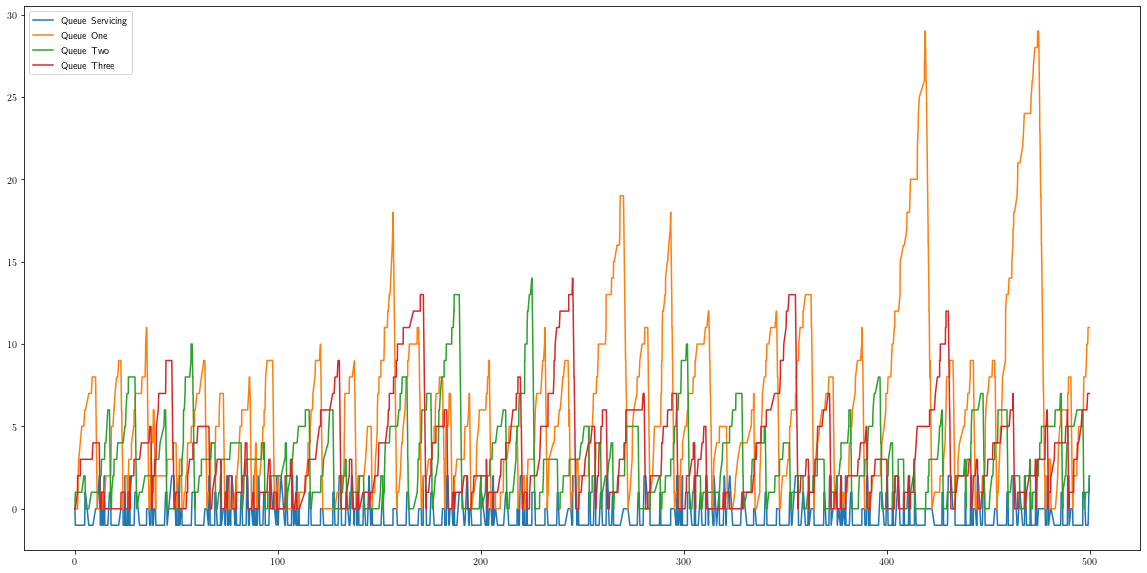

In [47]:
xt = np.array(xt)
fig = plt.figure(figsize=[20,10])
plt.plot(xt[:,0], xt[:,1], label = 'Queue Servicing')
plt.plot(xt[:,0], xt[:,2], label = 'Queue One')
plt.plot(xt[:,0], xt[:,3], label = 'Queue Two')
plt.plot(xt[:,0], xt[:,4], label = 'Queue Three')
plt.legend()
plt.show()

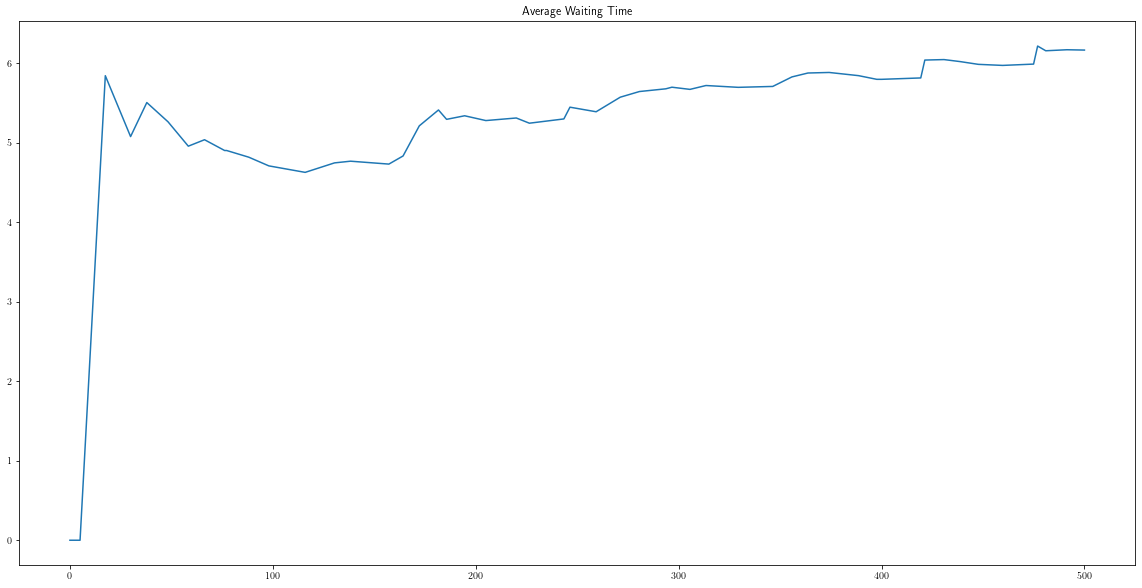

In [48]:
wt = np.array(wt)
fig = plt.figure(figsize=[20,10])
plt.plot(wt[:,0], wt[:,1])
plt.title("Average Waiting Time")
plt.show()

In [49]:
res = ps.calc_optiaml_rp(S)
print(res)

     fun: 4.906031021147757
     jac: array([3.89966959, 3.89420819, 3.89767259])
 message: 'Optimization terminated successfully'
    nfev: 54
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.07410498, 0.0310437 , 0.89485132])


4.906647130845505


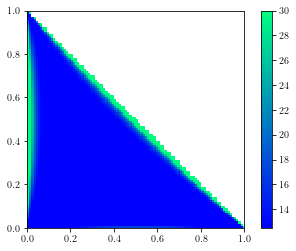

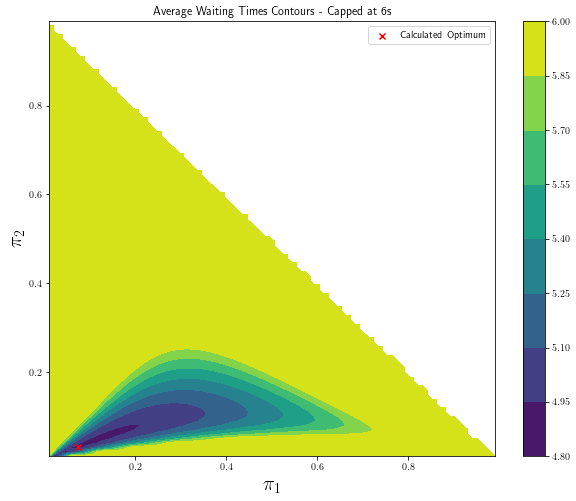

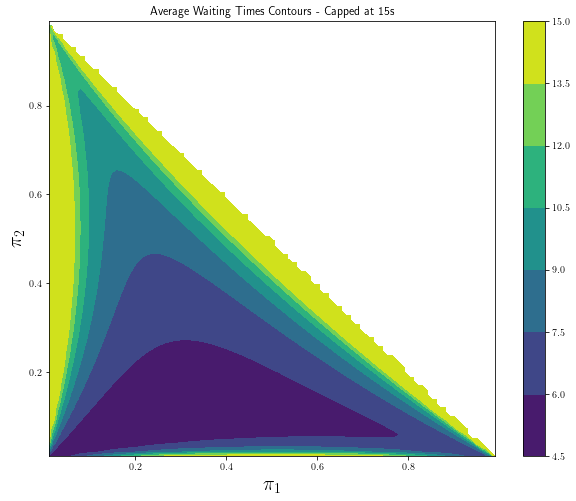

In [50]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

gran = 100
pi1 = np.linspace(1/gran,1-(1/gran), gran)
pi2 = np.linspace(1/gran,1 - (1/gran), gran)
Z = -1*np.Inf*np.ones([gran, gran])

fmin = 10000
for i in range(gran):
    for j in range(gran):
        pi = np.array([pi1[i], pi2[j], 1 - pi1[i] - pi2[j]])
        if pi[2] > 0:
            Z[i,j] = ps._calc_avg_wait_random( pi , S)
            if Z[i,j] < fmin:
                fmin=Z[i,j]
print(fmin)

fig, ax = plt.subplots()
ws = ax.imshow(np.transpose(Z), extent=[0,1,0,1], cmap='winter', interpolation='nearest',
               vmin=12.5,vmax=30, origin='lower')
fig.colorbar(ws)
plt.show()

fig = plt.figure(figsize=(10,8))
cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 6))
#cont = plt.contourf(pi1, pi2, np.minimum(np.log(Z.T), 2.6) )
fig.colorbar(cont)
plt.scatter(res.x[0], res.x[1], label='Calculated Optimum', marker='x', c='r')
plt.legend()
plt.title('Average Waiting Times Contours - Capped at 6s')
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)
plt.show()

fig = plt.figure(figsize=(10,8))
cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 15))
fig.colorbar(cont)
plt.title('Average Waiting Times Contours - Capped at 15s')
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)
plt.show()

In [10]:
#Contours are clearly non-convex. We're not dealing with a convex function.
#There doesn't seem to be a good way to verify unimodality, either